<a href="https://colab.research.google.com/github/kovzanok/dls-final-task/blob/main/1_FaceAlignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Alignment

## Архитектура Stacked Hourglass Network

**Hourglass** — это U-Net-подобная структура, которая сначала уменьшает разрешение изображения, затем восстанавливает его обратно. Такая структура напоминает по форме песочные часы (hourglass).

**Stacked Hourglass Network** состоит Hourglass-блоков, каждый из которых старается уточнять результат предыдущего. Несмотря на то, что она придумана в 2016 году, до сих пор используется во многих исследовательских проектах для задачи обнаружения ключевых точек.

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.49.50_PM.png)

### Hourglass module

Посмотрим подробнее на структуру **отдельного Hourglass-блока**

![retrt](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.50.12_PM.png)

Каждый бокс в этой схеме - это Residual block, который отвечает за извлечение признаков на разных уровнях детализации (вспоминаем про ResNet). Причем, каждый такой блок иммеет одинаковую размерность на входе и на выходе.

Downsampling и upsampling можно делать разными способами.

*   Для Downsampling: nn.MaxPool2d или nn.Conv2d
*   Для Upsampling: nn.Upsample или nn.ConvTranspose2d

Основная разница: maxpool и upsample - необучаемые слои в отличие от сверток. Это может как быть как минусом, так и плюсом: чем больше параметров - тем медленее идет процесс обучения (при этом не факт, что результаты будут лучше).

То есть, идейно все практически также как было в U-net: полностью симметричная архитектура, сначала идет преобразование в более низкоразмерное пространство, а потом декодирование обратно с пробросами результатов из соотвествующих слоев энкодера. Разница лишь в том, что теперь каждый кирпичик - это Residual block.

А вот реализация ResidualBlock вам в помощь!

Но можете ее править под себя, если очень хочется.

При построении архитектуры Hourglass-блоков **не обязательно полностью повторять архитектуру**, которая представлена на картинке из статьи. Вы можете добавлять больше или меньше модулей, некоторые блоки вообще можно не использовать. В целом, это творческая задача и вы вольны делать так, как вам самим хочется. **Главное - чтобы ваша реализация соотвествовала изначальной идее Hourglass, и итоговые результаты были достаточно хорошими.**

### Stacked Hourglass Network

Как и было сказано ранее, Stacked Hourglass - это набор одинаковых Hourglass блоков (см. схематический рисунок в начале ноутбука). Но что это за блок между каждыми двумя Hourglass? Чтобы ответить на этот вопрос, нужно сначала разобраться с тем, что мы будем получать на выходе такой нейронной сети.

Предсказывать ключевые точки лица можно поразному. Есть два основных подхода:

1.   Регрессия - предсказывает координаты точек лица напрямую -> $(N, x, y)$.
2.   Heatmap - предсказывает карту вероятностей на выходе, а наиболее подходящие точки находятся через argmax

Не вдваясь в подробности, можно просто сказать, что Heatmap-подход показал себя лучше из-за своей устойчивости к шумам и начальным условиям. В качестве функции потерь в таком случае используют обычный **MSE loss**.

В Stacked Hourglass **используется именно heatmap-подход**. И на выходе каждого Hourglass-блока находится слой (голова), который создает heatmap нужного размера. Обычно это какие-то стандартные варианты по типу *Conv -> BatchNorm -> Relu -> Conv* или просто *Conv*. Каждая heatmap'a прокидывается на следующую голову, и они суммируются, и так, пока слои не закончатся.

Такой подход нужен для реализации **Intermediate Supervision**. Если говорить простыми словами, то это такой вариант обучения нейронной сети, когда мы подсчитываем лосс не только по финальному выходу сети, а также на некоторых промежуточных слоях (головах). Градиенты в этом случае тоже распространяются не только через последний выход, но и через промежуточные уровни. Эти головы не влияют на финальное предсказание напрямую, но помогают модели быстрее и лучше учиться. На практике это означет следующее:

Нужно посчитать лосс (таргет для всех одинаковый) для каждой головы отдельно, а потом просуммировать. Далее Pytorch сам построит за вас весь граф вычислений и правильно запустит везде градиенты. В коде это выглядит так:

```
outputs = model(image)  # outputs — список из N heatmaps от разных голов
losses = [loss_function(output, target) for output in outputs]
total_loss = sum(losses)
total_loss.backward()
optimizer.step()
```

Подведем **итоги по архитектуре**.

Stacked Hourglass состоит из Hourglass-блоков, после каждого такого блока идет голова, которая предсказывает heatmap'у. Каждая heatmap'а суммируется с предыдущей. Градиенты при обучении текут с каждой головы, а не только через последний выход сети.

Подробно про Stacked Hourglass Network можно прочитать в [оригинальной статье](https://arxiv.org/pdf/1603.06937).

## Датасет

Есть множество датасетов для этой задачи, но для наших целей должно хватить и [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). К сожалению или к счастью в разметке там всего 5 точек

1.   Левый глаз
2.   Правый глаз
3.   Нос
4.   Левый уголок рта
5.   Правый уголок рта


Единственная проблема заключается в том, что разметка - это именно точки, а не heatmap'ы. Но можно их сгенерировать самостоятельно при помощи гауссовского распределения вокруг размеченных точек. Вот вам функции в помощь. Можете их тоже редактивовать под себя, если нужно.

Сам по себе CelebA избыточно большой для нашей задачи, поэтому можете использовать только его часть. Также, имеет смысл заранее кропнуть картинки таким образом, чтобы на них остались только лица, ну или по крайней мере минимум всего остального.

## Выравнивание по предсказанным точкам

Существует множество вариантов, как по полученным точкам правильно преобразовать картинку. Главное, что вам нужно понимать - **это задача классического компьютерного зрения** и решается при помощи математики, без нейронок. Вдаваться в подробности конкретных алгоритмов мы не будем.

Можно использовать аффинное преобразование, тогда потребуется только 3 точки, можно, например, искать матрицу гомографии, где может быть использовано больше точек, а может быть, есть еще что-то. Реализовывать эти алгоритмы самим не нужно. Достаточно провести небольшой ресерч и найти готовое решение (но **не готовую нейронку для выравнивания**), лишь бы оно работало. Количество используемых точек тоже выбирайте сами, подойдет любой вариант. Условный ориентир для поиска - библиотека **opencv**.

# План заданий

По итогу, в этом блоке у вас следующие задачи:


*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Подготовить датасет, преобразовав точки в Heatmap'ы
*   Обучить модель
*   Найти или реализовать функцию, которая бы по предсказанным ключевым точкам делала бы выравнивание лица на картинке (face alignment)

**P.S. Не забывайте сохранять модели после обучения и выводите промежуточные результаты на экран**



In [83]:
import numpy as np

def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark:(x, y) — координаты точки
    :param sigma
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
    :param sigma:
    :return: массив heatmap'ов вида [N, H, W]
    """
    heatmaps = []

    for landmark in landmarks:
        hm = create_heatmap(image_shape, landmark, sigma=sigma)
        heatmaps.append(hm)

    return np.array(heatmaps)

**Удачи! У вас всё получится 💗!**

In [5]:
!pip install -q kaggle

In [6]:
# Загрузи токен вручную (если у тебя уже есть kaggle.json):
from google.colab import files
files.upload()  # Загрузи файл kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kovzanok","key":"e4eea536140a3f662fb2a2c616b29a02"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
!kaggle datasets download -d jessicali9530/celeba-dataset -f list_landmarks_align_celeba.csv

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
list_landmarks_align_celeba.csv: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
!mv list_landmarks_align_celeba.csv list_landmarks_align_celeba.csv.zip

In [20]:
!unzip -q list_landmarks_align_celeba.csv.zip -d celeba

In [91]:
from torch import nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('/content/celeba/list_landmarks_align_celeba.csv',index_col=0)

In [58]:
def row_to_coords(row):
    return row.to_numpy().reshape(-1, 2)
# Добавим колонку с массивом координат:
landmarks_df = df.head(200).apply(row_to_coords, axis=1)

In [69]:
landmarks_array = landmarks_df.drop(columns=['image_name']).to_numpy().reshape(-1)

In [92]:
def show_heatmaps(heatmaps):
    # heatmaps — numpy array с формой (5, 128, 128)
    n = heatmaps.shape[0]
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(heatmaps[i], cmap='hot')
        plt.title(f'Heatmap {i+1}')
        plt.axis('off')
    plt.show()

# Пример вызова:
# show_heatmaps(твоя_heatmap_массив)


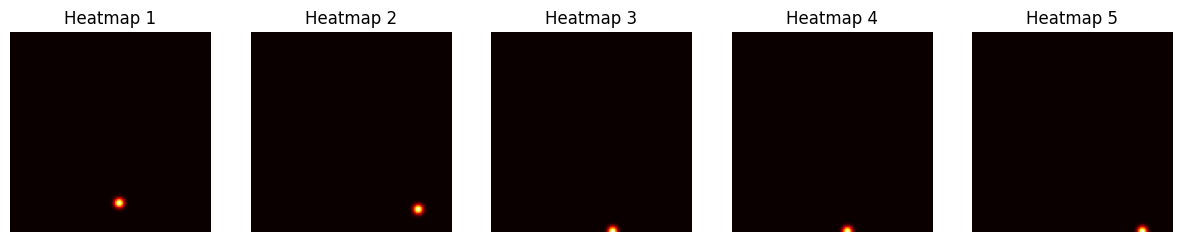

In [93]:
for landmark in landmarks_array:
    heat_map = landmarks_to_heatmaps((128,128),landmark)
    show_heatmaps(heat_map)
    break

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

In [3]:
class HourglassBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.res1 = ResidualBlock(channels, channels)
        self.res2 =  ResidualBlock(channels, channels)
        self.res_center =  ResidualBlock(channels, channels)
        self.res3 =  ResidualBlock(channels, channels)
        self.res4 =  ResidualBlock(channels, channels)

        self.downsample = nn.MaxPool2d(kernel_size=2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2,mode='nearest')

    def forward(self, x):
        skip1 = self.res1(x)
        x = self.downsample(skip1)
        skip2 = self.res2(x)
        x = self.downsample(skip2)
        x = self.res_center(x)
        x = self.upsample(x)
        x = self.res3(x)+skip2
        x = self.upsample(x)
        x = self.res4(x)+skip1
        return x

In [ ]:
class HourglassNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial_conv = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.hg1 = HourglassBlock(64)
        self.hg2 = HourglassBlock(64)
        self.hg3 = HourglassBlock(64)

        self.head1 = nn.Conv2d(64, 5)
        self.head2 = nn.Conv2d(64, 5)
        self.head3 = nn.Conv2d(64, 5)


    def forward(self, x):
        x = self.initial_conv(x)
        x = self.relu(self.bn(x))
        skip1 = self.hg1(x)
        res1 = self.head1(skip1)
        skip2 = self.hg2(skip1)+skip1
        res2 = self.head2(skip2)
        x = self.hg3(skip2)+skip2
        res3 = self.head3(x)
        return [res1, res2, res3]

